In [35]:
import torch
from torch.utils.data import  DataLoader,TensorDataset
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
from sklearn.model_selection import train_test_split
import category_encoders as ce
import torch

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from sklearn.metrics import r2_score
import numpy as np
import os
from sklearn.model_selection import GridSearchCV
import xgboost as xg
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import IsolationForest

In [2]:
df = pd.read_excel("house_price_without_categorical.xlsx")

In [3]:
categorical_columns = ['Neighborhood',"District","Usage","Heat_type","Floor"]

In [4]:
Y = df["Price"].values

# Drop the target column from the input features
X = df.drop(columns=["Price"])

In [5]:
df

,Unnamed: 0,District,Neighborhood,Num_Of_Room,Area,Floor,Age,Heat_type,Apt_Floor,Credit_Eli,Items,Num_of_Bath,Usage,Price
0,0,Gölbaşı,Hacılar,9,550.0,first floor,4,Kombi,3,1,0,6,Boş,17700000
1,1,Keçiören,Etlik,4,145.0,interstage,16,Kombi,4,1,0,2,Boş,2790000
2,2,Çankaya,Birlik,8,340.0,interstage,18,Kombi,4,1,0,3,Boş,4450000
3,3,Keçiören,Etlik,4,110.0,basement,25,Kombi,3,1,0,1,Mülk Sahibi,1249000
4,4,Çankaya,Keklik Pınarı,4,120.0,interstage,26,Kombi,10,1,0,1,Boş,2445000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20055,20055,Çankaya,Emek,6,180.0,top floor,25,Kombi,4,1,1,1,Boş,4500000
20056,20056,Polatlı,Zafer,7,340.0,top floor,11,Kombi,4,1,0,2,Mülk Sahibi,1395000
20057,20057,Çankaya,Yıldızevler,4,155.0,interstage,23,Merkezi,4,1,0,2,Boş,4750000
20058,20058,Keçiören,Bağlarbaşı,5,215.0,interstage,8,Kombi,10,1,0,2,Boş,4250000


In [6]:
# Calculate Q1, Q3, and IQR
Q1 = np.percentile(Y, 25)
Q3 = np.percentile(Y, 75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a boolean mask to identify outliers
mask = (Y > lower_bound) & (Y < upper_bound)

# Filter the DataFrame using the mask
df_filtered = df[mask]

In [7]:
df_filtered

,Unnamed: 0,District,Neighborhood,Num_Of_Room,Area,Floor,Age,Heat_type,Apt_Floor,Credit_Eli,Items,Num_of_Bath,Usage,Price
1,1,Keçiören,Etlik,4,145.0,interstage,16,Kombi,4,1,0,2,Boş,2790000
2,2,Çankaya,Birlik,8,340.0,interstage,18,Kombi,4,1,0,3,Boş,4450000
3,3,Keçiören,Etlik,4,110.0,basement,25,Kombi,3,1,0,1,Mülk Sahibi,1249000
4,4,Çankaya,Keklik Pınarı,4,120.0,interstage,26,Kombi,10,1,0,1,Boş,2445000
5,5,Çankaya,Emek,5,147.0,interstage,30,Merkezi,11,1,0,1,Kiracılı,4100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20055,20055,Çankaya,Emek,6,180.0,top floor,25,Kombi,4,1,1,1,Boş,4500000
20056,20056,Polatlı,Zafer,7,340.0,top floor,11,Kombi,4,1,0,2,Mülk Sahibi,1395000
20057,20057,Çankaya,Yıldızevler,4,155.0,interstage,23,Merkezi,4,1,0,2,Boş,4750000
20058,20058,Keçiören,Bağlarbaşı,5,215.0,interstage,8,Kombi,10,1,0,2,Boş,4250000


In [8]:
Y = df_filtered["Price"]

# Drop the target column from the input features
X = df_filtered.drop(columns=["Price"])

In [9]:
#value_counts = df['District'].value_counts()
#district_counts = {}

#for value, count in value_counts.items():
#    district_counts[value] = count

In [10]:
#filtered_df = df[df["District"] == "Çankaya"]



#filtered_df = filtered_df.drop(columns=['Neighborhood',"District"], axis=1)


#X = filtered_df.iloc[:, :-1].values
#Y = filtered_df["Price"].values/100000000

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [12]:
encoder = ce.TargetEncoder(cols=categorical_columns)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

In [13]:
X_train_encoded.shape

(15183, 13)

In [14]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler(feature_range=(0,1))
X_train_scaled = scaler_X.fit_transform(X_train_encoded)
X_test_scaled = scaler_X.transform(X_test_encoded)
Y_train_scaled = scaler_Y.fit_transform(y_train.reshape(-1,1))
Y_test_scaled = scaler_Y.transform(y_test.reshape(-1,1))

In [15]:
Y_train_scaled

array([[0.59006203],
       [0.43478249],
       [0.3312628 ],
       ...,
       [0.31055886],
       [0.28778453],
       [0.5983436 ]])

In [16]:
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(Y_train_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float()
y_test_tensor = torch.from_numpy(Y_test_scaled).float()

In [17]:
y_test_tensor = y_test_tensor.squeeze(1)


In [18]:
y_test_tensor

tensor([0.2795, 0.4037, 0.3518,  ..., 0.9265, 0.1418, 0.5383])

In [19]:
y_train_tensor = y_train_tensor.squeeze(1)

In [20]:
y_train_tensor

tensor([0.5901, 0.4348, 0.3313,  ..., 0.3106, 0.2878, 0.5983])

In [21]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)




In [22]:
class AdaptiveRelu(torch.nn.Module):
    def __init__(self, init_alpha =0.9, init_beta=0.1):
        super(AdaptiveRelu, self).__init__()
        self.alpha = torch.nn.Parameter(torch.tensor(init_alpha))
        self.beta = torch.nn.Parameter(torch.tensor(init_beta))
    def forward(self, x):
        return torch.tanh(self.alpha*x + self.beta) 



class Net(nn.Module):
    def __init__(self,L1,L2,L3,L4):
        super(Net,self).__init__()
  
        self.layers = nn.Sequential(
      nn.Linear(13,L1),
      AdaptiveRelu(),
      nn.Linear(L1,L2),
      AdaptiveRelu(),
      nn.Linear(L2,L3),
      AdaptiveRelu(),
      nn.Linear(L3,L4),
      AdaptiveRelu(),
      nn.Linear(L4,1),
    )
    def forward(self, x):
        return self.layers(x)

In [23]:
def train(dataloader,model,loss_fn,optimizer):
    
    model.train()
    running_loss = 0

    for batch,(x,y) in enumerate(dataloader):

        
        
        optimizer.zero_grad()
        output = model(x) 
        loss   = loss_fn(output.squeeze(),y)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    
    avg_loss = running_loss/len(dataloader) 
    

    
    return avg_loss

In [24]:
def validate(dataloader,model,loss_fn):

    
    model.eval() 
    running_loss = 0
    
    with torch.no_grad(): 
        
        for (x,y) in dataloader:
           
            output        = model(x)
            loss          = (loss_fn(output.squeeze(),y))
            
            running_loss += loss

    avg_loss = running_loss/len(dataloader)
      
    
    return avg_loss

In [25]:

model = Net(32,16,8,4)
loss_fn   = nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
nb_epochs = 500
batch_size = 32

In [26]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size , shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size , shuffle=False)

In [27]:

train_losses = []
valid_losses = []
train_loses_for_plot = []

for epoch in range(nb_epochs):
    
    

    train_loss = train(train_dataloader,model,loss_fn,optimizer)
    train_losses.append(train_loss)
    valid_loss = validate(test_dataloader,model,loss_fn) 
    valid_losses.append(valid_loss)
    if epoch % 10 == 0:
        print(f"Epoch : {epoch} train loss :{train_loss}  test loss : {valid_loss}  ")

    
    

Epoch : 0 train loss :0.03451046720147133  test loss : 0.03445363789796829  
Epoch : 10 train loss :0.03214741870760918  test loss : 0.032361820340156555  
Epoch : 20 train loss :0.029222508892416954  test loss : 0.029382333159446716  
Epoch : 30 train loss :0.02519156225025654  test loss : 0.025213003158569336  
Epoch : 40 train loss :0.021210677921772003  test loss : 0.021297721192240715  
Epoch : 50 train loss :0.019188638776540756  test loss : 0.019400108605623245  
Epoch : 60 train loss :0.018282011151313782  test loss : 0.018584392964839935  
Epoch : 70 train loss :0.017711201682686806  test loss : 0.018071811646223068  
Epoch : 80 train loss :0.017255567014217377  test loss : 0.017668867483735085  
Epoch : 90 train loss :0.01684478111565113  test loss : 0.01731320098042488  
Epoch : 100 train loss :0.01647147350013256  test loss : 0.016974618658423424  
Epoch : 110 train loss :0.016096599400043488  test loss : 0.0166303813457489  
Epoch : 120 train loss :0.01571638137102127  tes

R2 score: 0.6604


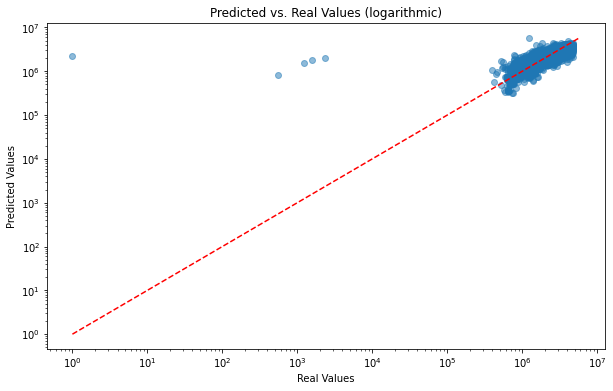

In [29]:
with torch.no_grad():
    
    y_pred_tensor = model(X_test_tensor)
    y_pred_scaled = y_pred_tensor.numpy().squeeze()


y_pred = scaler_Y.inverse_transform(y_pred_scaled.reshape(-1, 1)).squeeze()
y_test_unscaled = scaler_Y.inverse_transform(Y_test_scaled).squeeze()
r2 = r2_score(y_test_unscaled, y_pred)
print(f"R2 score: {r2:.4f}")

# Plot the predicted vs. real values with logarithmic scale
plt.figure(figsize=(10, 6))
plt.scatter(y_test_unscaled, y_pred, alpha=0.5)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Real Values (logarithmic)")

# Set the scale of the axes to logarithmic
plt.xscale("log")
plt.yscale("log")

# Add a diagonal line to visualize the perfect prediction
max_value = max(max(y_test_unscaled), max(y_pred))
plt.plot([1, max_value], [1, max_value], color="red", linestyle="--")
plt.show()

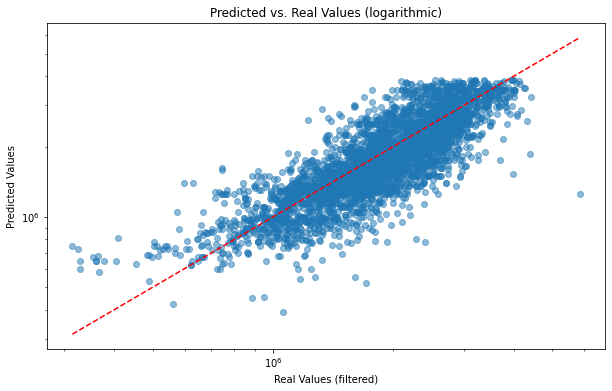

In [30]:
import numpy as np
from scipy import stats
model.eval()




# Calculate the Z-scores for y_test
z_scores = np.abs(stats.zscore(y_test))

# Set a threshold for the Z-score to remove outliers (e.g., 2 standard deviations from the mean)
threshold = 2

# Create a mask to filter out the outliers
mask = (z_scores < threshold)

# Apply the mask to y_test and y_pred_test_lr
y_test_filtered = y_pred[mask]
y_pred_filtered = y_test_unscaled[mask]

# Plot the filtered data with logarithmic scale
plt.figure(figsize=(10, 6))
plt.scatter(y_test_filtered, y_pred_filtered, alpha=0.5)
plt.xlabel("Real Values (filtered)")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Real Values (logarithmic)")

# Set the scale of the axes to logarithmic
plt.xscale("log")
plt.yscale("log")

# Add a diagonal line to visualize the perfect prediction
min_value_filtered = min(min(y_test_filtered), min(y_pred_filtered))
max_value_filtered = max(max(y_test_filtered), max(y_pred_filtered))
plt.plot([min_value_filtered, max_value_filtered], [min_value_filtered, max_value_filtered], color="red", linestyle="--")

plt.show()

In [31]:
xgb = xg.XGBRegressor()

param_grid = {
'n_estimators': [500],
'learning_rate': [0.05],
'max_depth': [5, 7],
'min_child_weight': [1, 5],
'subsample': [0.5,  1.0],
'colsample_bytree': [0.5, 1.0],
'gamma': [0, 0.1, 0.2],
'reg_alpha': [0, 0.5, 1],
'reg_lambda': [1, 1.5, 2],
"early_stopping_rounds":[25]
}


grid_search = GridSearchCV(
estimator=xgb,
param_grid=param_grid,
scoring='neg_mean_squared_error',
n_jobs=-1,
cv=2,
verbose=2
)


grid_search.fit(X_train_encoded, y_train,
        eval_set=[(X_train_encoded, y_train), (X_test_encoded, y_test)],
        verbose=False)       
best_model = grid_search.best_estimator_    

best_model.fit(X_train_encoded, y_train,
        eval_set=[(X_train_encoded, y_train), (X_test_encoded, y_test)],
        verbose=False)
y_pred_train_lr = best_model.predict(X_train_encoded)
y_pred_test_lr = best_model.predict(X_test_encoded)
mse_test_lr = MSE(y_test, y_pred_test_lr)
r2 = r2_score(y_test, y_pred_test_lr)

print(f"R2 score  : {r2}")


Fitting 2 folds for each of 432 candidates, totalling 864 fits
R2 score  : 0.8084042743029479


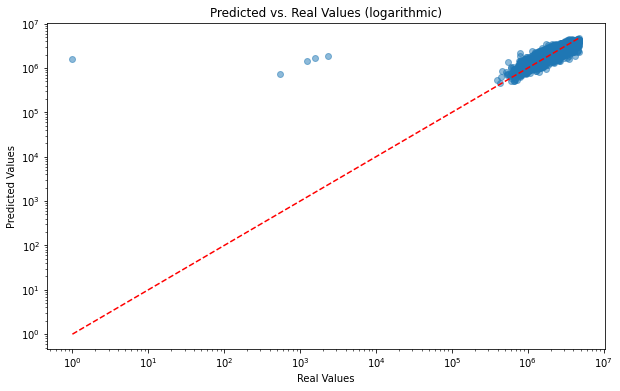

In [32]:


# Plot the predicted vs. real values with logarithmic scale
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test_lr, alpha=0.5)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Real Values (logarithmic)")

# Set the scale of the axes to logarithmic
plt.xscale("log")
plt.yscale("log")

# Add a diagonal line to visualize the perfect prediction
min_value = min(min(y_test), min(y_pred_test_lr))
max_value = max(max(y_test), max(y_pred_test_lr))
plt.plot([min_value, max_value], [min_value, max_value], color="red", linestyle="--")

plt.show()

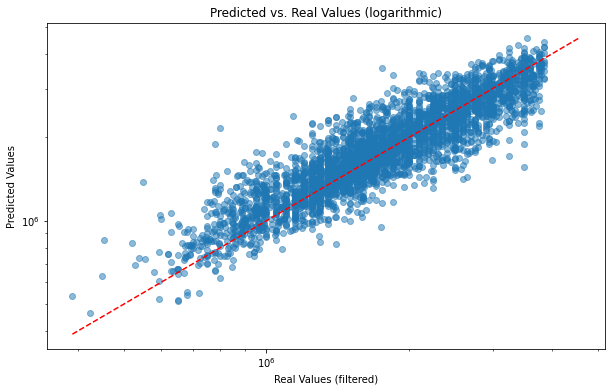

In [33]:
import numpy as np
from scipy import stats

# Calculate the Z-scores for y_test
z_scores = np.abs(stats.zscore(y_test))

# Set a threshold for the Z-score to remove outliers (e.g., 2 standard deviations from the mean)
threshold = 2

# Create a mask to filter out the outliers
mask = (z_scores < threshold)

# Apply the mask to y_test and y_pred_test_lr
y_test_filtered = y_test[mask]
y_pred_filtered = y_pred_test_lr[mask]

# Plot the filtered data with logarithmic scale
plt.figure(figsize=(10, 6))
plt.scatter(y_test_filtered, y_pred_filtered, alpha=0.5)
plt.xlabel("Real Values (filtered)")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Real Values (logarithmic)")

# Set the scale of the axes to logarithmic
plt.xscale("log")
plt.yscale("log")

# Add a diagonal line to visualize the perfect prediction
min_value_filtered = min(min(y_test_filtered), min(y_pred_filtered))
max_value_filtered = max(max(y_test_filtered), max(y_pred_filtered))
plt.plot([min_value_filtered, max_value_filtered], [min_value_filtered, max_value_filtered], color="red", linestyle="--")

plt.show()